(transd_gaussian_mixture)=
# Part II: Trans-dimensional GMM

In this tutorial, we demonstrate how to use BayesBay to retrieve a Gaussian Mixture Model (GMM) while treating the number of components in the mixture as a free parameter, to be inferred from the data. If you haven't already, we recommend reviewing [Part I: Known Number of Mixture Components](gaussian_mixture); this provides a detailed explanation of the code required to define and solve the simpler problem of deriving a GMM with a predetermined number of mixture components.

## Import libraries and define constants

In [1]:
import bayesbay as bb
from math import sqrt, pi
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(30)

In [2]:
MEANS = [140, 162, 177]  # Means of the Gaussians
STDS = [12, 5, 6]  # Standard deviations of the Gaussians
WEIGHTS = [0.4, 0.3, 0.3]  # Weights of each Gaussian in the mixture
N_SAMPLES = 10_000 # Number of samples to generate

In [3]:
def gaussian(x, mu, sigma):
    return 1 / (sigma * sqrt(2*pi)) * np.exp(-0.5 * ((x - mu) / sigma)**2)

## Observed data

In [4]:
assert np.isclose(sum(WEIGHTS), 1), "The weights must sum to 1."

def generate_random_samples(means, stds, weights):
    """Generate random samples for each component of the Gaussian mixture"""
    samples = []
    for mean, std, weight in zip(means, stds, weights):
        n_samples = int(N_SAMPLES * weight) # number of samples for each component
        samples.append(np.random.normal(mean, std, n_samples))
    samples = np.concatenate(samples)
    np.random.shuffle(samples)
    return samples

samples = generate_random_samples(MEANS, STDS, WEIGHTS)
data_obs, bins = np.histogram(samples, bins=50, density=True)
data_x = (bins[:-1] + bins[1:]) / 2 # Height associated with each data point

In [5]:
# Define the range of x-values (i.e., heights) over which to evaluate the PDF
x_min, x_max = min(MEANS) - 3 * max(STDS), max(MEANS) + 3 * max(STDS)
xs = np.linspace(x_min, x_max, 1000)

pdf_true = np.zeros_like(xs)
for mean, std, weight in zip(MEANS, STDS, WEIGHTS):
    pdf_true += weight * gaussian(xs, mean, std)

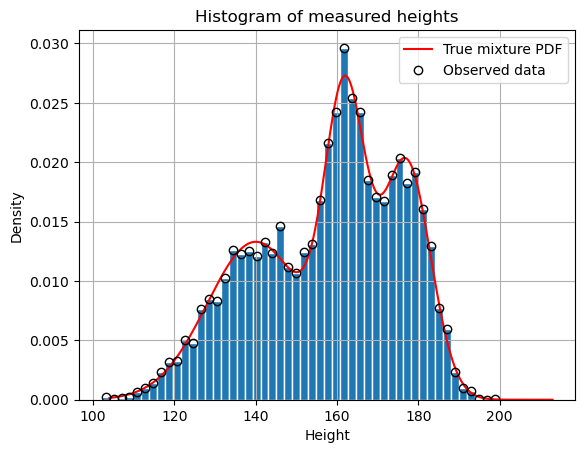

In [6]:
fig, ax = plt.subplots()
ax.set_title('Histogram of measured heights')
ax.hist(samples, bins=50, density=True, ec='w')
data_x = (bins[:-1] + bins[1:]) / 2 # take the midpoint of each bin
plt.plot(xs, pdf_true, label='True mixture PDF', color='r')
plt.plot(data_x, data_obs, 'ko', label='Observed data', markerfacecolor='None')

ax.set_xlabel('Height')
ax.set_ylabel('Density')
ax.grid()
ax.legend()
plt.show()

## Setting up the Bayesian sampling

### **Prior probability**

In [7]:
mean = bb.prior.UniformPrior(name="mean", vmin=100, vmax=200, perturb_std=2)
std = bb.prior.UniformPrior(name="std", vmin=1, vmax=20, perturb_std=0.4)
weight = bb.prior.UniformPrior(name="weight", vmin=0, vmax=1, perturb_std=0.02)

### **Parameter space and parameterization**

As explained in [Part I: Known Number of Mixture Components](gaussian_mixture), the above free parameters should be used in BayesBay to create what we call a [ParameterSpace](../api/generated/bayesbay.parameterization.ParameterSpace). `ParameterSpace` can be conceptualized as an $n$-dimensional vector space, or similarly, as a specialized container. It not only groups a number of free parameters but also determines their dimensionality.

```{important}
The dimensionality of `ParameterSpace` can be treated as unknown by setting `n_dimensions=None` at the initialization of the class instance, as shown in the following block. This enables the definition of trans-dimensional inference problems.
```

In this tutorial's case, `ParameterSpace` will contain three distinct free parameters (namely, $\boldsymbol{\omega}$, $\boldsymbol{\mu}$, and $\boldsymbol{\sigma}$). Each parameter is a vector whose dimensionality will align with that of `ParameterSpace` throughout the inversion process. Whenever a dimension is added to or removed from `ParameterSpace` (via a [BirthPerturbation](../api/generated/bayesbay.perturbations.BirthPerturbation)/[DeathPerturbation](../api/generated/bayesbay.perturbations.DeathPerturbation)), the dimensionality of the free parameters linked to it is correspondingly adjusted.

In [8]:
param_space = bb.parameterization.ParameterSpace(
    name='my_param_space', 
    n_dimensions=None, # Trans-dimensional setting
    n_dimensions_min=1, # Minimum number of dimensions (i.e., Gaussians in the mixture)
    n_dimensions_max=7, # Maximum number of dimensions (i.e., Gaussians in the mixture)
    parameters=[mean, std, weight], 
)
parameterization = bb.parameterization.Parameterization(param_space)

### **Forward problem**

In [9]:
def _forward(means, stds, weights):
    weights /= np.sum(weights)
    data_pred = np.zeros_like(data_x)
    for i in range(len(means)):
        data_pred += weights[i] * gaussian(data_x, means[i], stds[i])
    return data_pred

def fwd_function(state: bb.State) -> np.ndarray:
    means = state['my_param_space']['mean']
    stds = state['my_param_space']['std']
    weights = state['my_param_space']['weight']
    return _forward(means, stds, weights)

### **Observed data: the Target**

In [10]:
target = bb.Target('my_data', 
                   data_obs, 
                   std_min=0, 
                   std_max=0.01, 
                   std_perturb_std=0.001,
                   noise_is_correlated=False)

### **5. Log Likelihood**

In [11]:
log_likelihood = bb.LogLikelihood(targets=target, fwd_functions=fwd_function)

## Run the Bayesian sampling

Given the trans-dimensional nature of the inverse problem we are addressing, we will employ 20 Markov chains running in parallel for 400,000 iterations, discarding the initial 100,000 as part of the burn-in phase. Additionally, we set the temperature of each chain to 5 using our [SimulatedAnnealing](../api/generated/bayesbay.samplers.SimulatedAnnealing)  class (for details on simulated annealing, see [Kirkpatrick et al. 1983](Kirkpatrick83)). Temperatures higher than one downweight the impact of the likelihood ratio $\left[\frac{p\left(\mathbf{d}_{obs} \mid \mathbf{m'}\right)}{p\left(\mathbf{d}_{obs} \mid \mathbf{m}\right)}\right]^{\frac{1}{T}}$ on the acceptance probability of the perturbed model $\mathbf{m}'$, thereby enhancing each chain's exploration freedom. During the burn-in phase, the temperature of each chain is gradually reduced according to an exponential decay, reaching a value of 1 by the end of this phase.

```{seealso}
Through the module [bayesbay.samplers](../api/api_standard_samplers) you can implement arbitrary sampling criteria or use our built-in class [ParallelTempering](../api/generated/bayesbay.samplers.ParallelTempering) (e.g., [Sambridge 2014](Sambridge14)). 
```

In [12]:
inversion = bb.BayesianInversion(
    log_likelihood=log_likelihood, 
    parameterization=parameterization, 
    n_chains=20
)
inversion.run(
    sampler=bb.samplers.SimulatedAnnealing(temperature_start=5),
    n_iterations=450_000, 
    burnin_iterations=150_000, 
    save_every=100, 
    verbose=False, 
)

In [13]:
for chain in inversion.chains:
    chain.print_statistics()

Chain ID: 0
TEMPERATURE: 1
EXPLORED MODELS: 450000
ACCEPTANCE RATE: 65197/450000 (14.49 %)
PARTIAL ACCEPTANCE RATES:
	BirthPerturbation(my_param_space): 2825/75051 (3.76%)
	DeathPerturbation(my_param_space): 2822/73838 (3.82%)
	NoisePerturbation(my_data): 15740/74627 (21.09%)
	ParamPerturbation(['my_param_space.mean', 'my_param_space.std', 'my_param_space.weight']): 43810/226484 (19.34%)
Chain ID: 1
TEMPERATURE: 1
EXPLORED MODELS: 450000
ACCEPTANCE RATE: 66472/450000 (14.77 %)
PARTIAL ACCEPTANCE RATES:
	BirthPerturbation(my_param_space): 2908/75077 (3.87%)
	DeathPerturbation(my_param_space): 2906/74040 (3.92%)
	NoisePerturbation(my_data): 15748/75349 (20.90%)
	ParamPerturbation(['my_param_space.mean', 'my_param_space.std', 'my_param_space.weight']): 44910/225534 (19.91%)
Chain ID: 2
TEMPERATURE: 1
EXPLORED MODELS: 450000
ACCEPTANCE RATE: 59628/450000 (13.25 %)
PARTIAL ACCEPTANCE RATES:
	BirthPerturbation(my_param_space): 2613/75539 (3.46%)
	DeathPerturbation(my_param_space): 2611/74536

## Retrieve the results and plot

In the following blocks, we first plot an histogram of the ``ParameterSpace`` dimensionality of the sampled models, to verify that the majority of them corresponds to three Gaussians in the mixture. We then select all sampled models with three dimensions and plot the retrieved PDF and model parameters, as in [Part I: Known Number of Mixture Components](gaussian_mixture)

In [14]:
results = inversion.get_results()

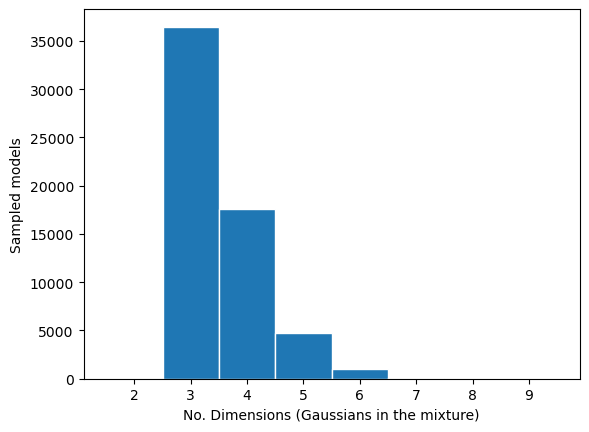

In [15]:
n_gaussians = results['my_param_space.n_dimensions']
fig, ax = plt.subplots()
ax.hist(n_gaussians, bins=np.arange(1.5, 10.5), ec='w')
ax.set_xlabel('No. Dimensions (Gaussians in the mixture)')
ax.set_ylabel('Sampled models')
plt.show()

In [16]:
idx = [i for i, n_comp in enumerate(n_gaussians) if n_comp==3]

def sort_mixture(means, stds, weights):
    indexes = [np.argsort(row) for row in means]
    for i, idx in enumerate(indexes):
        means[i] = means[i][idx]
        stds[i] = stds[i][idx]
        weights[i] = weights[i][idx]
    return means, stds, weights

means, stds, weights = sort_mixture(np.array([results['my_param_space.mean'][i] for i in idx]), 
                                    np.array([results['my_param_space.std'][i] for i in idx]), 
                                    np.array([results['my_param_space.weight'][i] for i in idx]))

In [17]:
# Estimate true data noise
datasets = [generate_random_samples(MEANS, STDS, WEIGHTS) for _ in range(10000)]
histograms = np.array([np.histogram(dataset, bins=50, density=True)[0] for dataset in datasets])
true_std = np.median(np.std(histograms, axis=0))

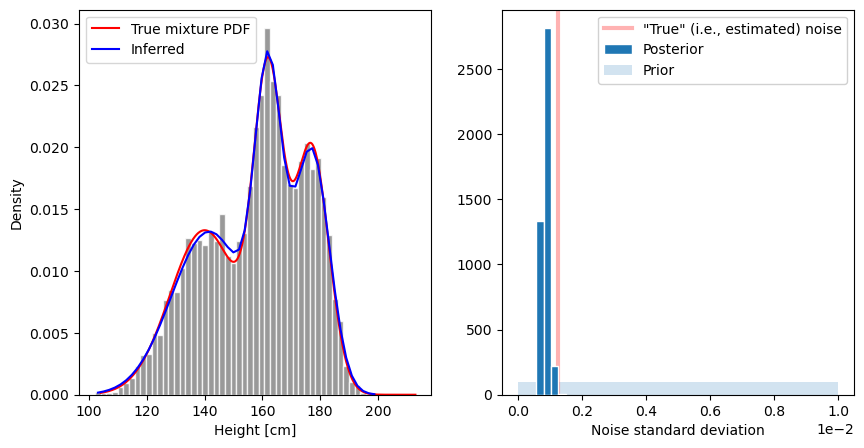

In [22]:
pdf_pred = _forward(np.median(means, axis=0), 
                    np.median(stds, axis=0), 
                    np.median(weights, axis=0)
                    )

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(samples, bins=50, density=True, ec='w', fc='gray', alpha=0.8)
ax1.plot(xs, pdf_true, label='True mixture PDF', color='r')
ax1.plot(data_x, pdf_pred, label='Inferred', color='b')
ax1.set_xlabel('Height [cm]')
ax1.set_ylabel('Density')
ax1.legend()

ax2.axvline(x=true_std, color='r', lw=3, alpha=0.3, label='"True" (i.e., estimated) noise')
pdf, bins, _ = ax2.hist(results['my_data.std'], density=True, bins=4, ec='w', zorder=100, label='Posterior')
ax2.fill_between([target.std_min, target.std_max], 1 / (target.std_max - target.std_min), alpha=0.2, label='Prior')
ax2.set_xlabel('Noise standard deviation')
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax2.legend(framealpha=0.9)
plt.show()

/home/fabrizio/mambaforge/envs/seislib/lib/python3.9/site-packages/arviz/plots/pairplot.py:232: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  gridsize = int(dataset.dims["draw"] ** 0.35)


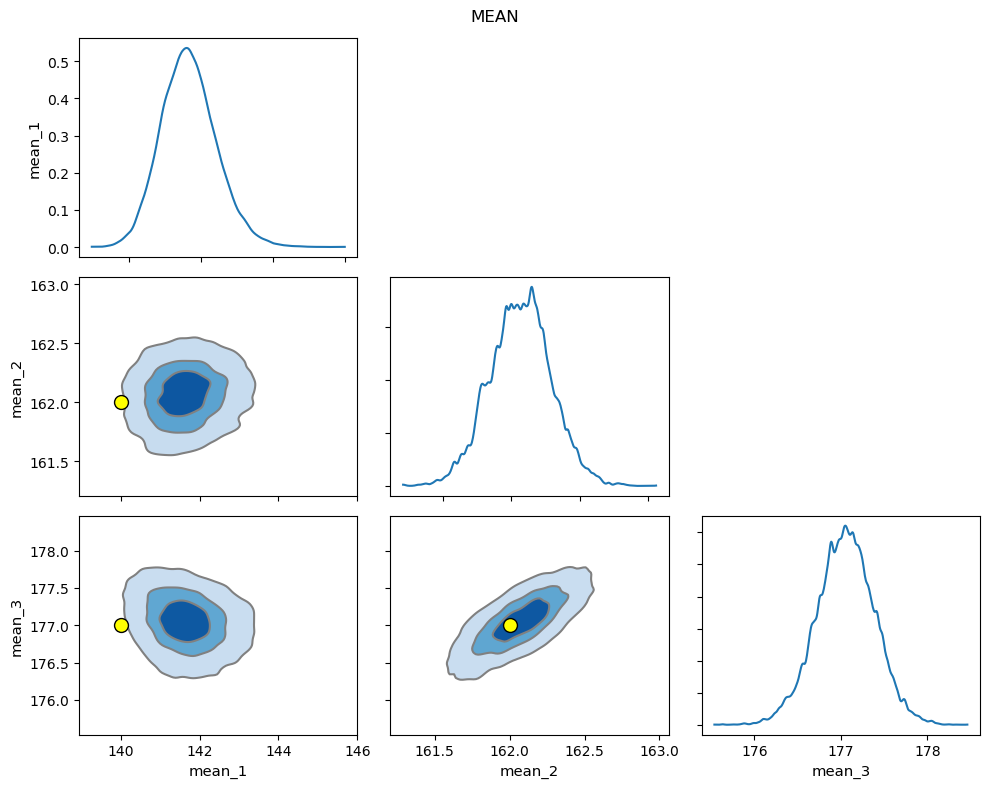

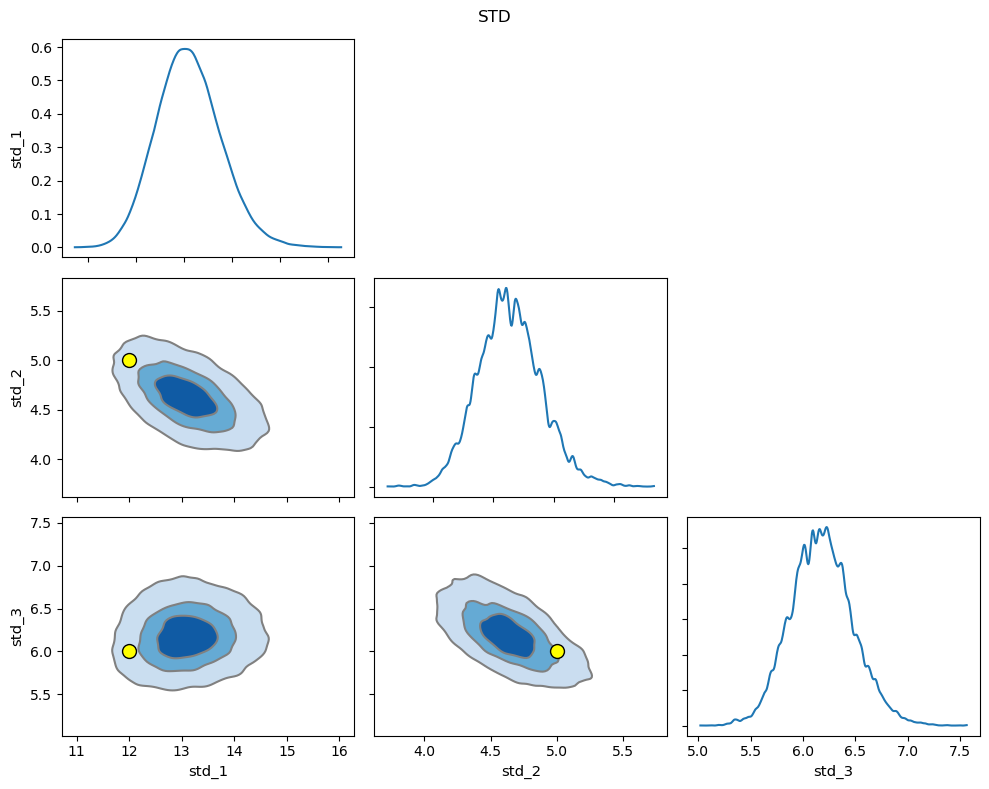

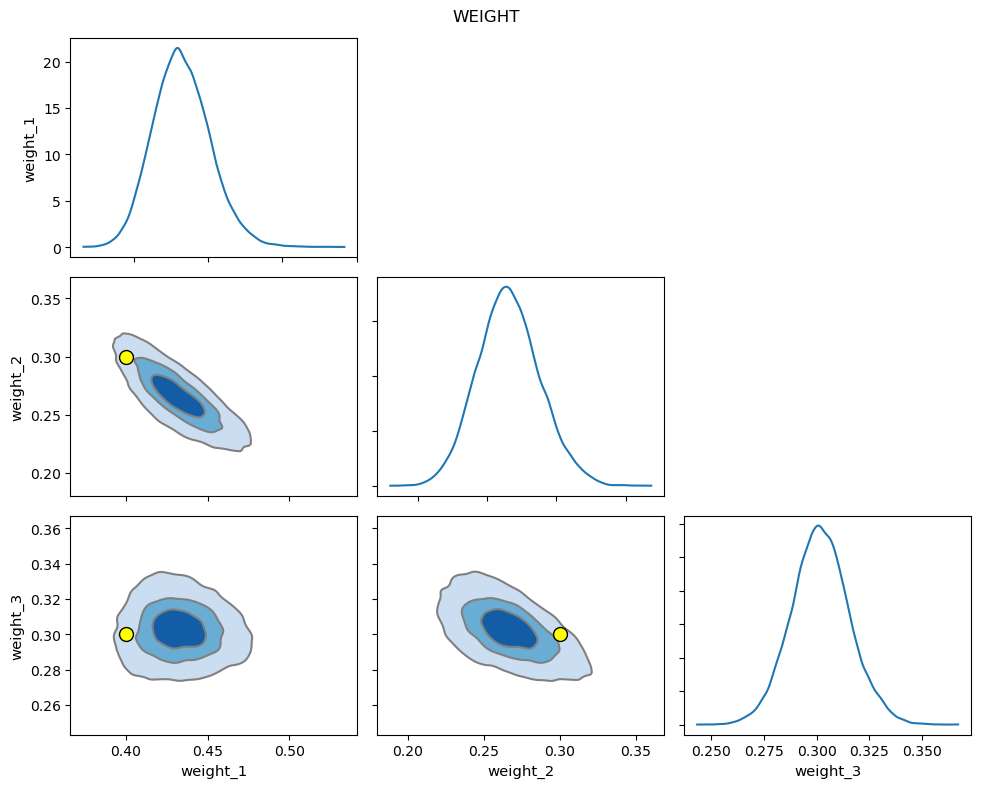

In [19]:
import arviz as az

for key, inferred_value, true_value in zip(
    ['mean', 'std', 'weight'], 
    [means, stds, weights],
    [MEANS, STDS, WEIGHTS]
                     ):
    fig, axes = plt.subplots(3, 3, figsize=(10, 8))
    _ = az.plot_pair(
        {f'{key}_1': inferred_value[:,0], 
         f'{key}_2': inferred_value[:,1], 
         f'{key}_3': inferred_value[:,2]},
        marginals=True,
        reference_values={f'{key}_1': true_value[0], 
                          f'{key}_2': true_value[1], 
                          f'{key}_3': true_value[2]},
        reference_values_kwargs={'color': 'yellow',
                                 'ms': 10},
        kind='kde',
        kde_kwargs={
            'hdi_probs': [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
            'contourf_kwargs': {'cmap': 'Blues'},
            },
        ax=axes,
        textsize=10
        )
    fig.suptitle(key.upper())
    plt.tight_layout()
    plt.show()

## References

(Kirkpatrick83)=
[1] Kirkpatrick et al. (1983), Optimization by simulated annealing. *Science*

(Sambridge14)=
[2] Sambridge (2014), A parallel tempering algorithm for probabilistic sampling and multimodal optimization. *Geophysical Journal International*